In [30]:
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import timeit
import time

In [31]:
def similarity(X1,X2, mode, params=None):
  if mode == 'eu2+':
    return 1/ (1 + pairwise_distances(X1, X2, metric='euclidean', n_jobs=None))
  if mode == 'gauss':
    return np.exp(-(pairwise_distances(X1, X2, metric='euclidean', n_jobs=None) ** 2) / 2 * params[0])

In [32]:
# labeled:
l1 = np.random.normal(loc=1, scale=1, size=(20, 2))
l2 = np.random.normal(loc=3, scale=1, size=(20, 2)) 

# unlabeled:
u1 = np.random.normal(loc=1, scale=1, size=(100, 2))
u2 = np.random.normal(loc=3, scale=1, size=(100, 2)) 

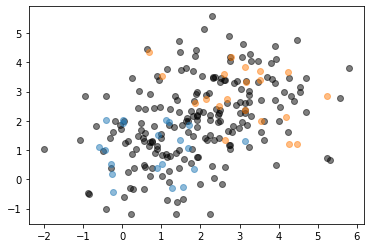

In [33]:
plt.scatter(u1[:, 0], u1[:, 1], alpha=0.5, c='black')
plt.scatter(u2[:, 0], u2[:, 1], alpha=0.5, c='black')
plt.scatter(l1[:, 0], l1[:, 1], alpha=0.5)
plt.scatter(l2[:, 0], l2[:, 1], alpha=0.5)
plt.show()

In [34]:
def loss_fun(W, W_bar, Y, Y_bar):
  sum = 0
  for i in range(0, len(Y_bar)):
    for j in range(0, len(Y)):
      sum += W[i,j] * (Y[j] - Y_bar[i]) ** 2
  for i in range(0, len(Y)):
    for j in range(0, len(Y)):
      sum += (W_bar[i,j] * (Y[i] - Y[j]) ** 2) / 2
  return sum

In [35]:
def grad_fun(W, W_bar, Y, Y_bar):
  grad = np.zeros((len(Y), 1))
  for j in range(0, len(grad)):
    for i in range(0, len(Y_bar)):
      grad[j] += W[i,j] * (Y[j] - Y_bar[i]) * 2
    for i in range(0, len(Y)):
      grad[j] += W_bar[i,j] * (Y[j] - Y[i]) * 2
  return grad

In [36]:
def grad_fun_block(W, W_bar, Y, Y_bar, j):
  grad = 0
  for i in range(0, len(Y_bar)):
    grad += W[i,j] * (Y[j] - Y_bar[i]) * 2
  for i in range(0, len(Y)):
    grad += W_bar[i,j] * (Y[j] - Y[i]) * 2
  return grad

In [37]:
def GD(W, W_bar, Y, Y_bar, alpha, max_it, toll):
  loss_history = []
  grad_norm_history = []
  time_history = []      

  loss = loss_fun(W, W_bar, Y, Y_bar)
  grad = grad_fun(W, W_bar, Y, Y_bar)

  start = timeit.default_timer()
  
  it = 0
  while it < max_it and np.linalg.norm(grad)>=toll:
    loss_history.append(loss)
    grad_norm_history.append(np.linalg.norm(grad))
    Y = Y - alpha * grad
    
    loss = loss_fun(W, W_bar, Y, Y_bar)
    grad = grad_fun(W, W_bar, Y, Y_bar)

    time_history.append(timeit.default_timer() - start)
    it = it+1
    #print(it)
  
  return Y, loss_history, grad_norm_history, time_history

In [38]:
def BCGD_cyclic(W, W_bar, Y, Y_bar, alpha, max_it, toll):
  
  loss_history = []
  grad_norm_history = []
  time_history = []     

  grad = np.ones((len(Y),1))
  start = timeit.default_timer()
  it = 0
  while it < max_it and np.linalg.norm(grad)>=toll:
    temp = Y
    for block in range(0, len(Y)):
      U_block = np.zeros((len(Y), 1)) 
      U_block[block] = 1
      grad[block] = grad_fun_block(W, W_bar, temp, Y_bar, block)
      temp = temp - alpha * U_block * grad[block]

    Y = temp
    loss = loss_fun(W, W_bar, Y, Y_bar)
    loss_history.append(loss)
    grad_norm_history.append(np.linalg.norm(grad))

    time_history.append(timeit.default_timer() - start)
    it = it+1
    #print(it)
  
  return Y, loss_history, grad_norm_history, time_history

In [39]:
#EXAMPLE
l = np.concatenate((l1,l2),axis=0)
u = np.concatenate((u1,u2),axis=0)
labels = np.ones((len(l1),1))
labels = np.concatenate((labels, -np.ones((len(l2),1))), axis=0)

W = similarity(l,u,'eu2+')
W_bar = similarity(u,u,'eu2+')
y = np.random.rand(len(u),1)
y[y>0.5] = 1
y[y<=0.5] = -1


In [ ]:
Y1, loss_history1, grad_norm_history1, time_history1 = GD(W, W_bar, y, labels, 1e-2, 100, 1e-2)           # terminates in 83 iterations
Y2, loss_history2, grad_norm_history2, time_history2 = BCGD_cyclic(W, W_bar, y, labels, 1e-2, 100, 1e-2)  # terminates in 72 iterations

In [41]:
print(loss_history1[-1])
print(loss_history2[-1])
print(grad_norm_history1[-1])
print(grad_norm_history2[-1])

[2618.66388276]
[2618.66300428]
0.5849544435469133
0.05096148193601021


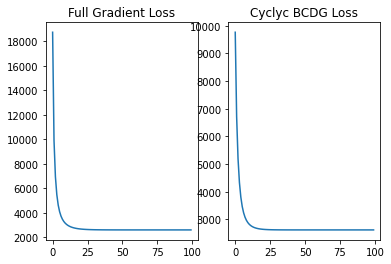

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(0, len(loss_history1)), loss_history1)
ax1.set_title('Full Gradient Loss')
ax2.plot(np.arange(0, len(loss_history2)), loss_history2)
ax2.set_title('Cyclic BCDG Loss')
plt.show()

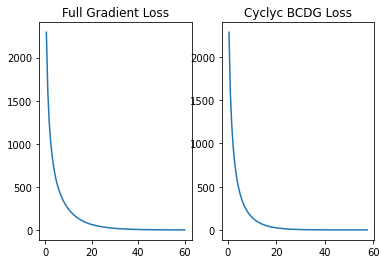

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(time_history1, grad_norm_history1)
ax1.set_title('Full Gradient Loss')
ax2.plot( time_history2, grad_norm_history2)
ax2.set_title('Cyclic BCDG Loss')
plt.show()